<a href="https://colab.research.google.com/github/siva-sankar-a/eva/blob/master/S4/EVA4_Session_2_MNIST_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments with on MNIST
### Objective:
- 99.4% validation accuracy
- Less than 20k Parameters
- Less than 20 Epochs
- No fully connected layer

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
!pip install torchsummary
!pip install torchviz
!pip install receptivefield>=0.5.0

import datetime
import glob

import numpy as np
import pandas as pd

from __future__ import print_function        # Import for print statement
import torch                                 # Import pytorch library
import torch.nn as nn                        # Import neural net module from pytorch
import torch.nn.functional as F              # Import functional interface from pytorch
import torch.optim as optim                  # Import optimizer module from pytorch

from torchvision import datasets, transforms # Import datasets and augmentation functionality from vision module within pytorch
from torchsummary import summary             # Import summary with pytorch
from torchviz import make_dot

from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable

from receptivefield.pytorch import PytorchReceptiveField

import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm

In [0]:
use_cuda = torch.cuda.is_available()                  # Check cuda avaliability

##Get MNIST Dataset

In [0]:
torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', 
                   train=True, 
                   download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
                    batch_size=batch_size, 
                    shuffle=True, 
                    **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', 
                   train=False, 
                   transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
                    batch_size=batch_size, 
                    shuffle=True, 
                    **kwargs)

##Experiment 1
###Strategy
  - Brute-force shrinking number of parameters
  - GAP layer

In [0]:
experiment_name = 'gap-layer'

###Model

In [0]:
# Subclassing nn.Module for neural networks
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1, bias=False)     # input image size - (1, 28, 28) output image size - (1, 28, 28)  local RF - ( 3, 3 ) global RF - (  3,  3 )
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1, bias=False)     # input image size - (1, 28, 28) output image size - (1, 28, 28)  local RF - ( 3, 3 ) global RF - (  5,  5 )
        self.pool1 = nn.MaxPool2d(2, 2)                            # input image size - (1, 28, 28) output image size - (1, 14, 14)  local RF - ( 3, 3 ) global RF - ( 10, 10 )
        
        self.conv3 = nn.Conv2d(8, 16, 3, padding=1, bias=False)    # input image size - (1, 14, 14) output image size - (1, 14, 14)  local RF - ( 3, 3 ) global RF - ( 12, 12 )
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1, bias=False)   # input image size - (1, 14, 14) output image size - (1, 14, 14)  local RF - ( 3, 3 ) global RF - ( 14, 14 )
        self.conv5 = nn.Conv2d(16, 16, 3, padding=1, bias=False)   # input image size - (1, 14, 14) output image size - (1, 14, 14)  local RF - ( 3, 3 ) global RF - ( 16, 16 )
        self.conv6 = nn.Conv2d(16, 16, 3, padding=1, bias=False)   # input image size - (1, 14, 14) output image size - (1, 14, 14)  local RF - ( 3, 3 ) global RF - ( 18, 18 )
        self.conv7 = nn.Conv2d(16, 16, 3, padding=1, bias=False)   # input image size - (1, 14, 14) output image size - (1, 14, 14)  local RF - ( 3, 3 ) global RF - ( 18, 18 )
        self.pool2 = nn.MaxPool2d(2, 2)                            # input image size - (1, 14, 14) output image size - (1,  7,  7)  local RF - ( 3, 3 ) global RF - ( 20, 20 )
        
        self.conv8 = nn.Conv2d(16, 32, 3, padding=1, bias=False)   # input image size - (1,  7,  7) output image size - (1,  7,  7)  local RF - ( 3, 3 ) global RF - ( 22, 22 )
        self.conv9 = nn.Conv2d(32, 10, 3, padding=1, bias=False)   # input image size - (1,  7,  7) output image size - (1,  7,  7)  local RF - ( 3, 3 ) global RF - ( 24, 24 )
        self.pool3 = nn.AdaptiveAvgPool2d((1, 1))                  # input image size - (1,  7,  7) output image size - (1,  1,  1)  local RF - ( 3, 3 ) global RF - ( 26, 26 )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))                       
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))                       
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))             
        x = self.pool2(x) 
        x = F.relu(self.conv8(x))
        x = self.pool3(self.conv9(x))
        x = x.view(-1, 10)                    # Flatten
        return F.log_softmax(x, dim=1)        # Log of softmax function

###Summary

####Textual summary

In [7]:
device = torch.device("cuda" if use_cuda else "cpu") # Initializing GPU
model = Net().to(device)                             # Initializing model and transfering to GPU
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
            Conv2d-2            [-1, 8, 28, 28]             576
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           1,152
            Conv2d-5           [-1, 16, 14, 14]           2,304
            Conv2d-6           [-1, 16, 14, 14]           2,304
            Conv2d-7           [-1, 16, 14, 14]           2,304
            Conv2d-8           [-1, 16, 14, 14]           2,304
         MaxPool2d-9             [-1, 16, 7, 7]               0
           Conv2d-10             [-1, 32, 7, 7]           4,608
           Conv2d-11             [-1, 10, 7, 7]           2,880
AdaptiveAvgPool2d-12             [-1, 10, 1, 1]               0
Total params: 18,504
Trainable params: 18,504
Non-trainable params: 0
---------------------------------

####Graphical summary

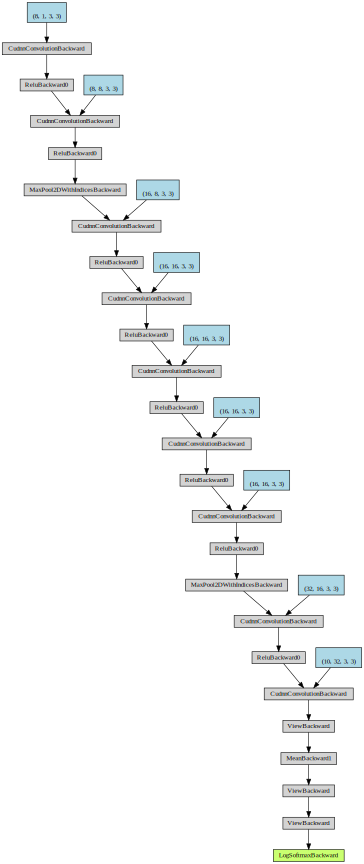

In [8]:
random_input = torch.randn(1, 1, 28, 28).cuda() if use_cuda else torch.randn(1, 1, 28, 28) 
model.eval()
y = model(Variable(random_input))
dot_graph = make_dot(y)
dot_graph.format = 'svg'
dot_graph.render(f'{experiment_name}')
dot_graph

### Training

In [0]:
def train(model, device, train_loader, optimizer, epoch, writer):
    model.train()
    train_loss = 0
    correct = 0
    pbar = tqdm(train_loader)
    train_len = len(train_loader.dataset)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        batch_loss = F.nll_loss(output, target)
        train_loss += batch_loss  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        batch_loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'TRAIN : epoch={epoch} train_loss={(train_loss / train_len):.5f} correct/total={correct}/{train_len} accuracy={(100. * correct / train_len):.1f}')
        writer.add_scalar('train/batch_loss', batch_loss, epoch * train_len + batch_idx)
    
    train_loss /= train_len
    train_accuracy = 100. * correct / train_len
    writer.add_scalar('loss', train_loss, epoch)
    writer.add_scalar('accuracy', train_accuracy, epoch)

def test(model, device, test_loader, epoch, writer):
    model.eval()
    test_loss = 0
    correct = 0
    pbar = tqdm(test_loader)
    test_len = len(test_loader.dataset)
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            output = model(data)
            batch_loss = F.nll_loss(output, target, reduction='sum').item()  # batch loss
            test_loss += batch_loss  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            pbar.set_description(desc= f'TEST :  epoch={epoch} test_loss={(test_loss / test_len):.5f} correct/total={correct}/{test_len} accuracy=\033[1m{(100. * correct / test_len):.1f}\033[0m')
            writer.add_scalar('test/batch_loss', batch_loss, epoch * test_len + batch_idx)

    test_loss /= test_len
    test_accuracy = 100. * correct / test_len
    writer.add_scalar('loss', test_loss, epoch)
    writer.add_scalar('accuracy', test_accuracy, epoch)

    '''
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, test_len,
        100. * correct / test_len))
    '''

In [10]:
now = datetime.datetime.now()
prefix = f"{experiment_name}_{now.strftime('%m-%d-%y %H:%M:%S')}"

train_writer = SummaryWriter(f'/content/drive/My Drive/log_mnist/run_train_{prefix}')
test_writer = SummaryWriter(f'/content/drive/My Drive/log_mnist/run_test_{prefix}')

model = Net().to(device)
lr = 0.01
epochs = 20
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(0, epochs):
    train(model, device, train_loader, optimizer, epoch, train_writer)
    test(model, device, test_loader, epoch, test_writer)

TRAIN : epoch=0 train_loss=0.03600 correct/total=6330/60000 accuracy=10.6: 100%|██████████| 938/938 [00:22<00:00, 41.71it/s]
TEST :  epoch=0 test_loss=2.30229 correct/total=980/10000 accuracy=9.8: 100%|██████████| 157/157 [00:03<00:00, 45.71it/s]
TRAIN : epoch=1 train_loss=0.02464 correct/total=24012/60000 accuracy=40.0: 100%|██████████| 938/938 [00:22<00:00, 41.98it/s]
TEST :  epoch=1 test_loss=0.41069 correct/total=8779/10000 accuracy=87.8: 100%|██████████| 157/157 [00:03<00:00, 46.81it/s]
TRAIN : epoch=2 train_loss=0.00340 correct/total=56116/60000 accuracy=93.5: 100%|██████████| 938/938 [00:22<00:00, 41.64it/s]
TEST :  epoch=2 test_loss=0.11479 correct/total=9629/10000 accuracy=96.3: 100%|██████████| 157/157 [00:03<00:00, 46.17it/s]
TRAIN : epoch=3 train_loss=0.00194 correct/total=57752/60000 accuracy=96.3: 100%|██████████| 938/938 [00:22<00:00, 42.17it/s]
TEST :  epoch=3 test_loss=0.06737 correct/total=9784/10000 accuracy=97.8: 100%|██████████| 157/157 [00:03<00:00, 47.25it/s]
TRA

###Results

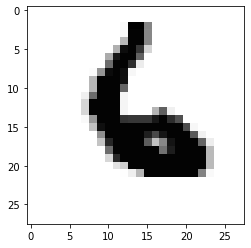

In [11]:
sample_index = 2
batch_data = next(iter(train_loader))[0]
x = next(iter(train_loader))[0][sample_index : sample_index + 1]
plt.set_cmap('Greys')
plt.imshow(x.view((28, 28)))
plt.show()

In [0]:
def get_activations(model):
  model.eval()
  activations = {}
  def get_activation(name):
      def hook(model, input, output):
          activations[name] = np.hstack(output.squeeze(0).cpu().detach().numpy())
          # print(name, activations[name].shape)
      return hook

  model.conv2.register_forward_hook(get_activation('Block 1'))
  model.conv7.register_forward_hook(get_activation('Block 2'))
  model.conv9.register_forward_hook(get_activation('Block 3'))
  model.pool3.register_forward_hook(get_activation('Output'))

  y = model(Variable(x.cuda() if use_cuda else x))
  return activations

In [0]:
activations = get_activations(model)

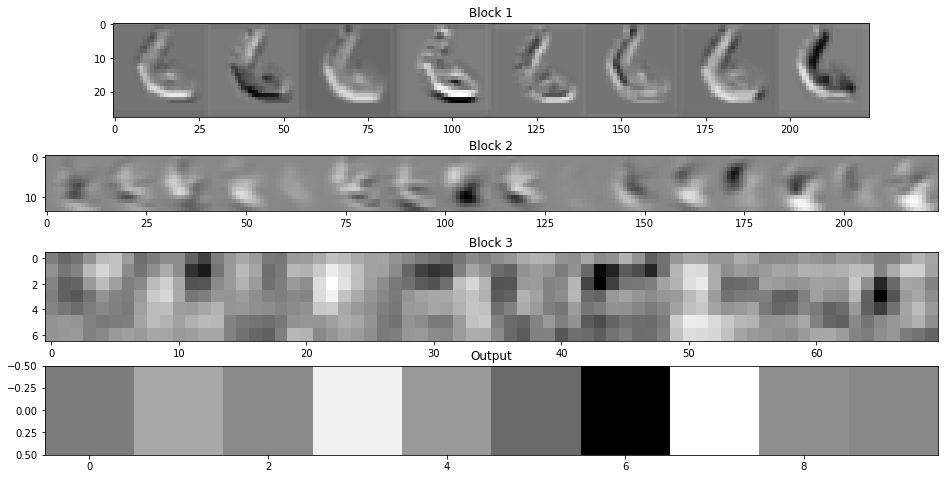

In [14]:
layer_activations = list(activations.items())
fig=plt.figure(figsize=(16, 8))
columns = 1
rows = len(layer_activations)
for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    layer, activation = layer_activations[i - 1]
    plt.title(layer)
    plt.set_cmap('Greys')
    plt.imshow(activation)
plt.show()

##Experiment 2
###Strategy
  - Use batch-normalization layer per convolution layer

In [0]:
experiment_name = 'batch-norm'

###Model

In [0]:
# Subclassing nn.Module for neural networks
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1, bias=False)     # input image size - (1, 28, 28) output image size - (1, 28, 28)  local RF - ( 3, 3 ) global RF - (  3,  3 )
        self.bn1   = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1, bias=False)     # input image size - (1, 28, 28) output image size - (1, 28, 28)  local RF - ( 3, 3 ) global RF - (  5,  5 )
        self.bn2   = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(2, 2)                            # input image size - (1, 28, 28) output image size - (1, 14, 14)  local RF - ( 3, 3 ) global RF - ( 10, 10 )
        
        self.conv3 = nn.Conv2d(8, 16, 3, padding=1, bias=False)    # input image size - (1, 14, 14) output image size - (1, 14, 14)  local RF - ( 3, 3 ) global RF - ( 12, 12 )
        self.bn3   = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1, bias=False)   # input image size - (1, 14, 14) output image size - (1, 14, 14)  local RF - ( 3, 3 ) global RF - ( 14, 14 )
        self.bn4   = nn.BatchNorm2d(16)
        self.conv5 = nn.Conv2d(16, 16, 3, padding=1, bias=False)   # input image size - (1, 14, 14) output image size - (1, 14, 14)  local RF - ( 3, 3 ) global RF - ( 16, 16 )
        self.bn5   = nn.BatchNorm2d(16)
        self.conv6 = nn.Conv2d(16, 16, 3, padding=1, bias=False)   # input image size - (1, 14, 14) output image size - (1, 14, 14)  local RF - ( 3, 3 ) global RF - ( 18, 18 )
        self.bn6   = nn.BatchNorm2d(16)
        self.conv7 = nn.Conv2d(16, 16, 3, padding=1, bias=False)   # input image size - (1, 14, 14) output image size - (1, 14, 14)  local RF - ( 3, 3 ) global RF - ( 18, 18 )
        self.bn7   = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(2, 2)                            # input image size - (1, 14, 14) output image size - (1,  7,  7)  local RF - ( 3, 3 ) global RF - ( 20, 20 )
        
        self.conv8 = nn.Conv2d(16, 32, 3, padding=1, bias=False)   # input image size - (1,  7,  7) output image size - (1,  7,  7)  local RF - ( 3, 3 ) global RF - ( 22, 22 )
        self.bn8   = nn.BatchNorm2d(32)
        self.conv9 = nn.Conv2d(32, 10, 3, padding=1, bias=False)   # input image size - (1,  7,  7) output image size - (1,  7,  7)  local RF - ( 3, 3 ) global RF - ( 24, 24 )
        self.pool3 = nn.AdaptiveAvgPool2d((1, 1))                  # input image size - (1,  7,  7) output image size - (1,  1,  1)  local RF - ( 3, 3 ) global RF - ( 26, 26 )

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = F.relu(self.bn3(self.conv3(x)))                       
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))                       
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))             
        x = self.pool2(x) 
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool3(self.conv9(x))
        x = x.view(-1, 10)                    # Flatten
        return F.log_softmax(x, dim=1)        # Log of softmax function

###Summary

####Textual summary

In [17]:
device = torch.device("cuda" if use_cuda else "cpu") # Initializing GPU
model = Net().to(device)                             # Initializing model and transfering to GPU
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3            [-1, 8, 28, 28]             576
       BatchNorm2d-4            [-1, 8, 28, 28]              16
         MaxPool2d-5            [-1, 8, 14, 14]               0
            Conv2d-6           [-1, 16, 14, 14]           1,152
       BatchNorm2d-7           [-1, 16, 14, 14]              32
            Conv2d-8           [-1, 16, 14, 14]           2,304
       BatchNorm2d-9           [-1, 16, 14, 14]              32
           Conv2d-10           [-1, 16, 14, 14]           2,304
      BatchNorm2d-11           [-1, 16, 14, 14]              32
           Conv2d-12           [-1, 16, 14, 14]           2,304
      BatchNorm2d-13           [-1, 16, 14, 14]              32
           Conv2d-14           [-1, 16,

####Graphical summary

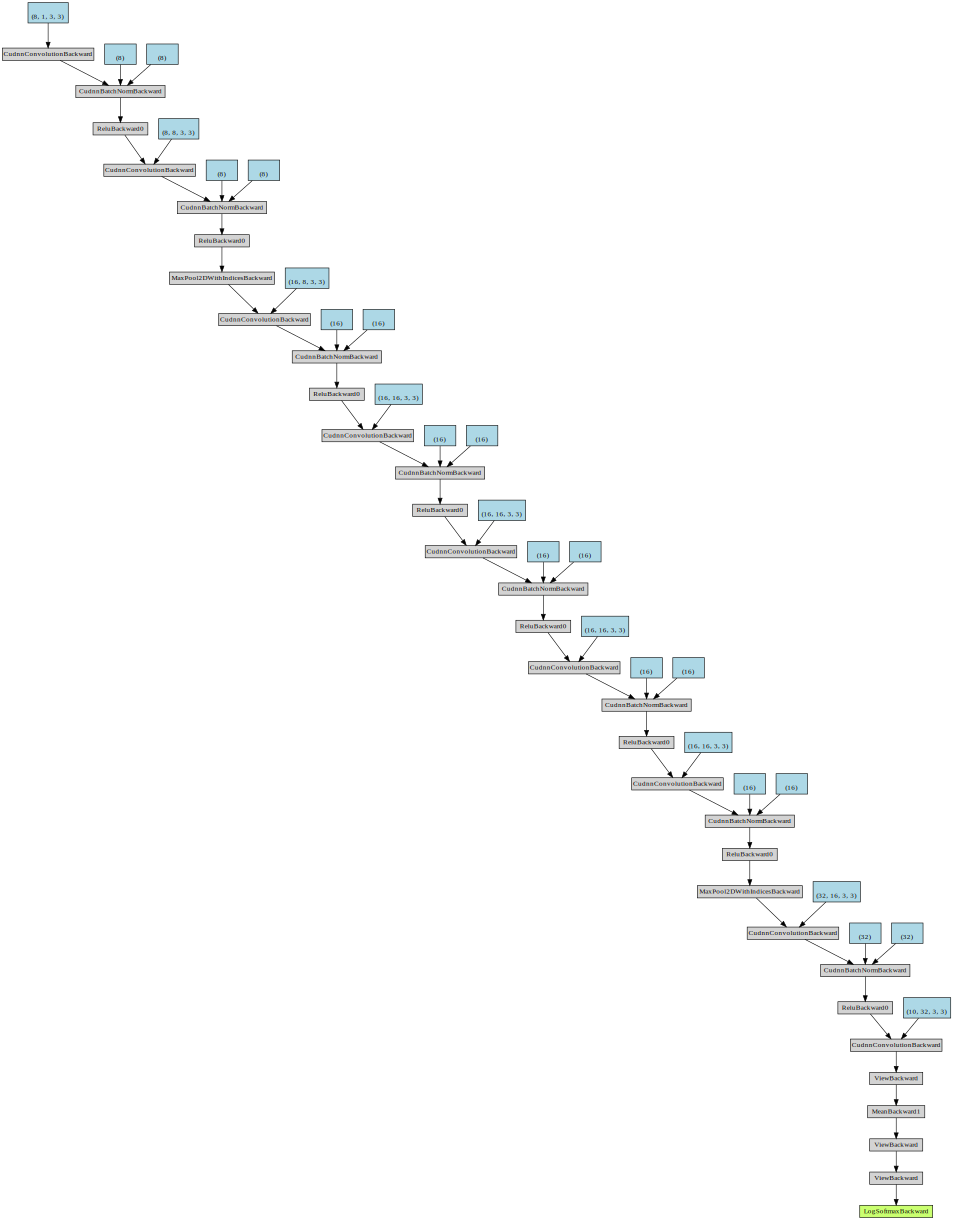

In [18]:
random_input = torch.randn(1, 1, 28, 28).cuda() if use_cuda else torch.randn(1, 1, 28, 28) 
model.eval()
y = model(Variable(random_input))
dot_graph = make_dot(y)
dot_graph.format = 'svg'
dot_graph.render(f'{experiment_name}')
dot_graph

### Training

In [0]:
def train(model, device, train_loader, optimizer, epoch, writer):
    model.train()
    train_loss = 0
    correct = 0
    pbar = tqdm(train_loader)
    train_len = len(train_loader.dataset)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        batch_loss = F.nll_loss(output, target)
        train_loss += batch_loss  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        batch_loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'TRAIN : epoch={epoch} train_loss={(train_loss / train_len):.5f} correct/total={correct}/{train_len} accuracy={(100. * correct / train_len):.1f}')
        writer.add_scalar('train/batch_loss', batch_loss, epoch * train_len + batch_idx)
    
    train_loss /= train_len
    train_accuracy = 100. * correct / train_len
    writer.add_scalar('loss', train_loss, epoch)
    writer.add_scalar('accuracy', train_accuracy, epoch)

def test(model, device, test_loader, epoch, writer):
    model.eval()
    test_loss = 0
    correct = 0
    pbar = tqdm(test_loader)
    test_len = len(test_loader.dataset)
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            output = model(data)
            batch_loss = F.nll_loss(output, target, reduction='sum').item()  # batch loss
            test_loss += batch_loss  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            pbar.set_description(desc= f'TEST :  epoch={epoch} test_loss={(test_loss / test_len):.5f} correct/total={correct}/{test_len} accuracy=\033[1m{(100. * correct / test_len):.1f}\033[0m')
            writer.add_scalar('test/batch_loss', batch_loss, epoch * test_len + batch_idx)

    test_loss /= test_len
    test_accuracy = 100. * correct / test_len
    writer.add_scalar('loss', test_loss, epoch)
    writer.add_scalar('accuracy', test_accuracy, epoch)

In [20]:
now = datetime.datetime.now()
prefix = f"{experiment_name}_{now.strftime('%m-%d-%y %H:%M:%S')}"

train_writer = SummaryWriter(f'/content/drive/My Drive/log_mnist/run_train_{prefix}')
test_writer = SummaryWriter(f'/content/drive/My Drive/log_mnist/run_test_{prefix}')

model = Net().to(device)
lr = 0.01
epochs = 20
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(0, epochs):
    train(model, device, train_loader, optimizer, epoch, train_writer)
    test(model, device, test_loader, epoch, test_writer)

TRAIN : epoch=0 train_loss=0.00407 correct/total=55292/60000 accuracy=92.2: 100%|██████████| 938/938 [00:25<00:00, 37.36it/s]
TEST :  epoch=0 test_loss=0.12327 correct/total=9607/10000 accuracy=96.1: 100%|██████████| 157/157 [00:03<00:00, 44.56it/s]
TRAIN : epoch=1 train_loss=0.00087 correct/total=58966/60000 accuracy=98.3: 100%|██████████| 938/938 [00:25<00:00, 36.76it/s]
TEST :  epoch=1 test_loss=0.03799 correct/total=9884/10000 accuracy=98.8: 100%|██████████| 157/157 [00:04<00:00, 39.02it/s]
TRAIN : epoch=2 train_loss=0.00064 correct/total=59219/60000 accuracy=98.7: 100%|██████████| 938/938 [00:25<00:00, 37.24it/s]
TEST :  epoch=2 test_loss=0.03343 correct/total=9899/10000 accuracy=99.0: 100%|██████████| 157/157 [00:03<00:00, 45.34it/s]
TRAIN : epoch=3 train_loss=0.00050 correct/total=59392/60000 accuracy=99.0: 100%|██████████| 938/938 [00:24<00:00, 37.60it/s]
TEST :  epoch=3 test_loss=0.04116 correct/total=9882/10000 accuracy=98.8: 100%|██████████| 157/157 [00:03<00:00, 44.30it/s]


###Results

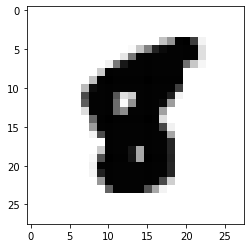

In [21]:
sample_index = 2
batch_data = next(iter(train_loader))[0]
x = next(iter(train_loader))[0][sample_index : sample_index + 1]
plt.set_cmap('Greys')
plt.imshow(x.view((28, 28)))

In [0]:
def get_activations(model):
  model.eval()
  activations = {}
  def get_activation(name):
      def hook(model, input, output):
          activations[name] = np.hstack(output.squeeze(0).cpu().detach().numpy())
          # print(name, activations[name].shape)
      return hook

  model.bn2.register_forward_hook(get_activation('Block 1'))
  model.bn7.register_forward_hook(get_activation('Block 2'))
  model.conv9.register_forward_hook(get_activation('Block 3'))
  model.pool3.register_forward_hook(get_activation('Output'))

  y = model(Variable(x.cuda() if use_cuda else x))
  return activations

In [0]:
activations = get_activations(model)

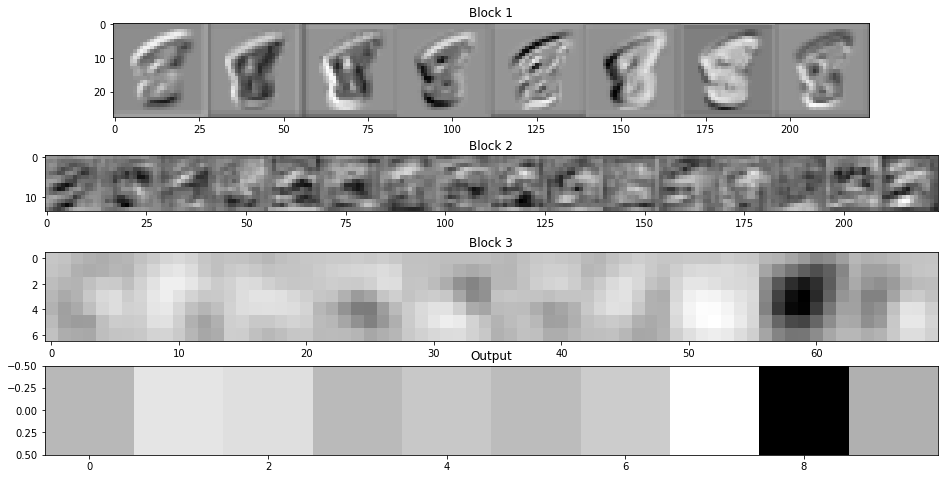

In [24]:
layer_activations = list(activations.items())
fig=plt.figure(figsize=(16, 8))
columns = 1
rows = len(layer_activations)
for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    layer, activation = layer_activations[i - 1]
    plt.title(layer)
    plt.set_cmap('Greys')
    plt.imshow(activation)
plt.show()

##Experiment 3
###Strategy
  - Use batch normalization and dropout

In [0]:
experiment_name = 'batch_norm_dropout'

###Model

In [0]:
# Subclassing nn.Module for neural networks
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, 3, padding=1, bias=False)     # input image size - (1, 28, 28) output image size - (1, 28, 28)  local RF - ( 3, 3 ) global RF - (  3,  3 )
        self.bn1   = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1, bias=False)     # input image size - (1, 28, 28) output image size - (1, 28, 28)  local RF - ( 3, 3 ) global RF - (  5,  5 )
        self.bn2   = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(2, 2)                            # input image size - (1, 28, 28) output image size - (1, 14, 14)  local RF - ( 3, 3 ) global RF - ( 10, 10 )
        self.drop1 = nn.Dropout2d(p=0.1)

        self.conv3 = nn.Conv2d(8, 16, 3, padding=1, bias=False)    # input image size - (1, 14, 14) output image size - (1, 14, 14)  local RF - ( 3, 3 ) global RF - ( 12, 12 )
        self.bn3   = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1, bias=False)   # input image size - (1, 14, 14) output image size - (1, 14, 14)  local RF - ( 3, 3 ) global RF - ( 14, 14 )
        self.bn4   = nn.BatchNorm2d(16)
        self.conv5 = nn.Conv2d(16, 16, 3, padding=1, bias=False)   # input image size - (1, 14, 14) output image size - (1, 14, 14)  local RF - ( 3, 3 ) global RF - ( 16, 16 )
        self.bn5   = nn.BatchNorm2d(16)
        self.conv6 = nn.Conv2d(16, 16, 3, padding=1, bias=False)   # input image size - (1, 14, 14) output image size - (1, 14, 14)  local RF - ( 3, 3 ) global RF - ( 18, 18 )
        self.bn6   = nn.BatchNorm2d(16)
        self.conv7 = nn.Conv2d(16, 16, 3, padding=1, bias=False)   # input image size - (1, 14, 14) output image size - (1, 14, 14)  local RF - ( 3, 3 ) global RF - ( 18, 18 )
        self.bn7   = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(2, 2)                            # input image size - (1, 14, 14) output image size - (1,  7,  7)  local RF - ( 3, 3 ) global RF - ( 20, 20 )
        self.drop2 = nn.Dropout2d(p=0.1)

        self.conv8 = nn.Conv2d(16, 32, 3, padding=1, bias=False)   # input image size - (1,  7,  7) output image size - (1,  7,  7)  local RF - ( 3, 3 ) global RF - ( 22, 22 )
        self.bn8   = nn.BatchNorm2d(32)
        self.conv9 = nn.Conv2d(32, 10, 3, padding=1, bias=False)   # input image size - (1,  7,  7) output image size - (1,  7,  7)  local RF - ( 3, 3 ) global RF - ( 24, 24 )
        self.drop3 = nn.Dropout2d(p=0.1)
        
        self.pool3 = nn.AdaptiveAvgPool2d((1, 1))                  # input image size - (1,  7,  7) output image size - (1,  1,  1)  local RF - ( 3, 3 ) global RF - ( 26, 26 )
        self.is_logging = False

    def forward(self, x):
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.drop1(self.pool1(x))
        
        x = F.relu(self.bn3(self.conv3(x)))                       
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))                       
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.drop2(self.pool2(x))

        x = F.relu(self.bn8(self.conv8(x)))
        x = self.drop3(self.conv9(x))

        x = self.pool3(x)
        x = x.view(-1, 10)                    # Flatten
        return F.log_softmax(x, dim=1)        # Log of softmax function

###Summary

####Textual summary

In [49]:
device = torch.device("cuda" if use_cuda else "cpu") # Initializing GPU
model = Net().to(device)                             # Initializing model and transfering to GPsummary(model, input_size=(1, 28, 28))
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3            [-1, 8, 28, 28]             576
       BatchNorm2d-4            [-1, 8, 28, 28]              16
         MaxPool2d-5            [-1, 8, 14, 14]               0
         Dropout2d-6            [-1, 8, 14, 14]               0
            Conv2d-7           [-1, 16, 14, 14]           1,152
       BatchNorm2d-8           [-1, 16, 14, 14]              32
            Conv2d-9           [-1, 16, 14, 14]           2,304
      BatchNorm2d-10           [-1, 16, 14, 14]              32
           Conv2d-11           [-1, 16, 14, 14]           2,304
      BatchNorm2d-12           [-1, 16, 14, 14]              32
           Conv2d-13           [-1, 16, 14, 14]           2,304
      BatchNorm2d-14           [-1, 16,

####Graphical summary

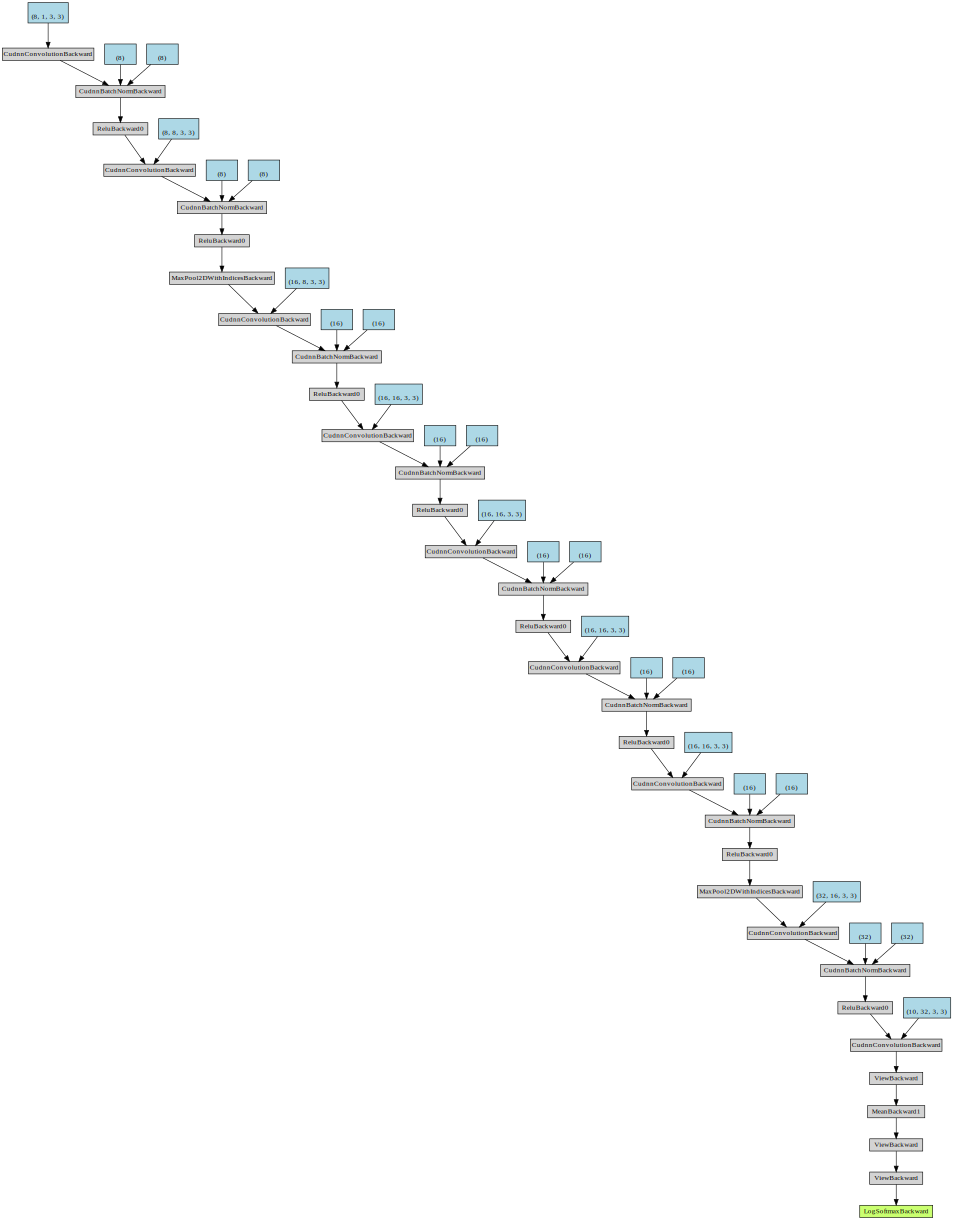

In [52]:
random_input = torch.randn(1, 1, 28, 28).cuda() if use_cuda else torch.randn(1, 1, 28, 28) 
model.eval()
y = model(Variable(random_input))
dot_graph = make_dot(y)
dot_graph.format = 'svg'
dot_graph.render(f'{experiment_name}')
dot_graph

### Training

In [0]:
def train(model, device, train_loader, optimizer, epoch, writer):
    model.train()
    train_loss = 0
    correct = 0
    pbar = tqdm(train_loader)
    train_len = len(train_loader.dataset)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        batch_loss = F.nll_loss(output, target)
        train_loss += batch_loss  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        batch_loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'TRAIN : epoch={epoch} train_loss={(train_loss / train_len):.5f} correct/total={correct}/{train_len} accuracy={(100. * correct / train_len):.1f}')
        writer.add_scalar('train/batch_loss', batch_loss, epoch * train_len + batch_idx)
    
    train_loss /= train_len
    train_accuracy = 100. * correct / train_len
    writer.add_scalar('loss', train_loss, epoch)
    writer.add_scalar('accuracy', train_accuracy, epoch)

def test(model, device, test_loader, epoch, writer):
    model.eval()
    test_loss = 0
    correct = 0
    pbar = tqdm(test_loader)
    test_len = len(test_loader.dataset)
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            output = model(data)
            batch_loss = F.nll_loss(output, target, reduction='sum').item()  # batch loss
            test_loss += batch_loss  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            pbar.set_description(desc= f'TEST :  epoch={epoch} test_loss={(test_loss / test_len):.5f} correct/total={correct}/{test_len} accuracy=\033[1m{(100. * correct / test_len):.1f}\033[0m')
            writer.add_scalar('test/batch_loss', batch_loss, epoch * test_len + batch_idx)

    test_loss /= test_len
    test_accuracy = 100. * correct / test_len
    writer.add_scalar('loss', test_loss, epoch)
    writer.add_scalar('accuracy', test_accuracy, epoch)

In [55]:
now = datetime.datetime.now()
prefix = f"{experiment_name}_{now.strftime('%m-%d-%y %H:%M:%S')}"

train_writer = SummaryWriter(f'/content/drive/My Drive/log_mnist/run_train_{prefix}')
test_writer = SummaryWriter(f'/content/drive/My Drive/log_mnist/run_test_{prefix}')

model = Net().to(device)
lr = 0.01
epochs = 20
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(0, epochs):
    train(model, device, train_loader, optimizer, epoch, train_writer)
    test(model, device, test_loader, epoch, test_writer)

TRAIN : epoch=0 train_loss=0.00829 correct/total=49018/60000 accuracy=81.7: 100%|██████████| 938/938 [00:25<00:00, 36.14it/s]
TEST :  epoch=0 test_loss=0.06391 correct/total=9817/10000 accuracy=98.2: 100%|██████████| 157/157 [00:03<00:00, 43.31it/s]
TRAIN : epoch=1 train_loss=0.00278 correct/total=55945/60000 accuracy=93.2: 100%|██████████| 938/938 [00:26<00:00, 35.77it/s]
TEST :  epoch=1 test_loss=0.03780 correct/total=9875/10000 accuracy=98.8: 100%|██████████| 157/157 [00:03<00:00, 39.82it/s]
TRAIN : epoch=2 train_loss=0.00226 correct/total=56480/60000 accuracy=94.1: 100%|██████████| 938/938 [00:25<00:00, 36.16it/s]
TEST :  epoch=2 test_loss=0.04183 correct/total=9869/10000 accuracy=98.7: 100%|██████████| 157/157 [00:03<00:00, 43.72it/s]
TRAIN : epoch=3 train_loss=0.00207 correct/total=56677/60000 accuracy=94.5: 100%|██████████| 938/938 [00:25<00:00, 36.40it/s]
TEST :  epoch=3 test_loss=0.02509 correct/total=9915/10000 accuracy=99.2: 100%|██████████| 157/157 [00:03<00:00, 44.85it/s]


###Results

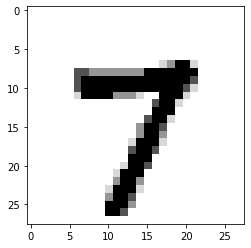

In [56]:
sample_index = 2
batch_data, batch_target = next(iter(train_loader))
x = batch_data[sample_index : sample_index + 1]
y_target = batch_target[sample_index].unsqueeze(0)
plt.set_cmap('Greys')
plt.imshow(x.view((28, 28)))
plt.show()

In [0]:
def get_activations(model):
  model.eval()
  activations = {}
  def get_activation(name):
    def hook(layer, input, output):
      activations[name] = np.hstack(output.squeeze(0).cpu().detach().numpy())
    return hook

  handle1 = model.bn2.register_forward_hook(get_activation('Block 1'))
  handle2 = model.bn7.register_forward_hook(get_activation('Block 2'))
  handle3 = model.conv9.register_forward_hook(get_activation('Block 3'))
  handle4 = model.pool3.register_forward_hook(get_activation('Output'))

  y = model(Variable(x.cuda() if use_cuda else x))

  handle1.remove()
  handle2.remove()
  handle3.remove()
  handle4.remove()

  return activations

In [0]:
activations = get_activations(model)

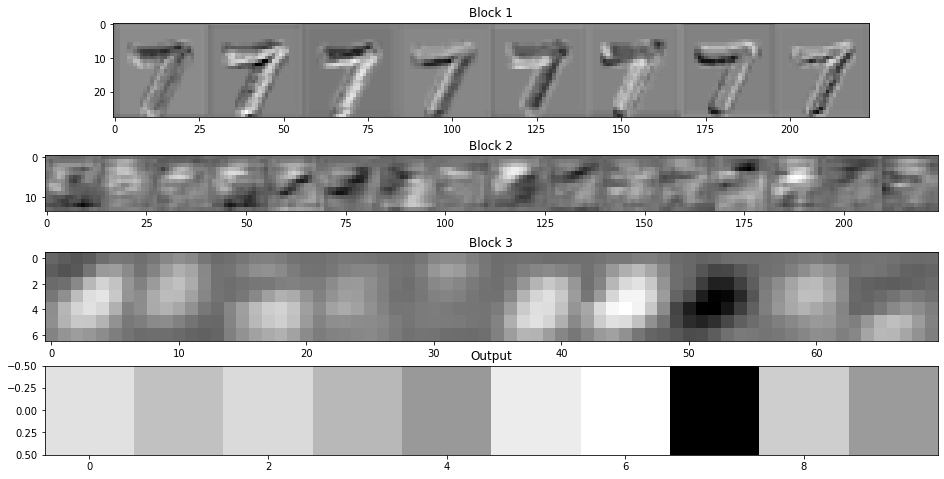

In [59]:
layer_activations = list(activations.items())
fig=plt.figure(figsize=(16, 8))
columns = 1
rows = len(layer_activations)
for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    layer, activation = layer_activations[i - 1]
    plt.title(layer)
    plt.set_cmap('Greys')
    plt.imshow(activation)
plt.show()

## Overall results

In [0]:
experiment_1 = 'gap-layer'
experiment_2 = 'batch-norm'
experiment_3 = 'batch_norm_dropout'

train_1 = glob.glob(f'/content/drive/My Drive/log_mnist/run_train_{experiment_1}_*/events.out.tfevents.*')[-1]
test_1 = glob.glob(f'/content/drive/My Drive/log_mnist/run_test_{experiment_1}_*/events.out.tfevents.*')[-1]

train_2 = glob.glob(f'/content/drive/My Drive/log_mnist/run_train_{experiment_2}_*/events.out.tfevents.*')[-1]
test_2 = glob.glob(f'/content/drive/My Drive/log_mnist/run_test_{experiment_2}_*/events.out.tfevents.*')[-1]

train_3 = glob.glob(f'/content/drive/My Drive/log_mnist/run_train_{experiment_3}_*/events.out.tfevents.*')[-1]
test_3 = glob.glob(f'/content/drive/My Drive/log_mnist/run_test_{experiment_3}_*/events.out.tfevents.*')[-1]

In [0]:
experiment_data = {experiment_1: (train_1, test_1), experiment_2: (train_2, test_2), experiment_3: (train_3, test_3)}
summary = {}
for experiment, (train, test) in experiment_data.items():
  train_data = {}
  test_data = {}
  summary[experiment] = {}
  for e in tf.compat.v1.train.summary_iterator(train):
      for v in e.summary.value:
          if v.tag not in train_data:
              train_data[v.tag] = []
          train_data[v.tag].append(v.simple_value)
  for e in tf.compat.v1.train.summary_iterator(test):
        for v in e.summary.value:
            if v.tag not in test_data:
                test_data[v.tag] = []
            test_data[v.tag].append(v.simple_value)
  summary[experiment]['train'] = train_data
  summary[experiment]['test'] = test_data

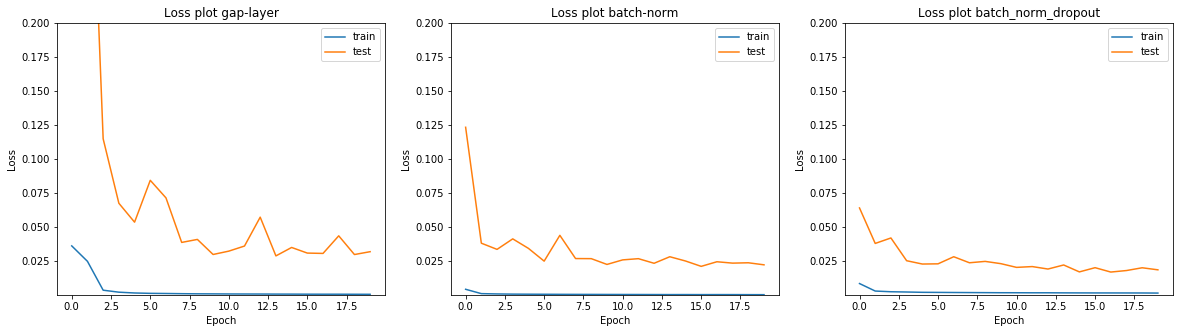

In [62]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))
for idx, experiment in enumerate(experiment_data.keys()):
  axs[idx].plot(summary[experiment]['train']['loss'])
  axs[idx].plot(summary[experiment]['test']['loss'])
  axs[idx].set_title(f'Loss plot {experiment}')
  axs[idx].set_ylabel('Loss')
  axs[idx].set_xlabel('Epoch')
  axs[idx].set_ylim([1e-5, 0.2])
  axs[idx].legend(['train', 'test'], loc='best')
plt.show()

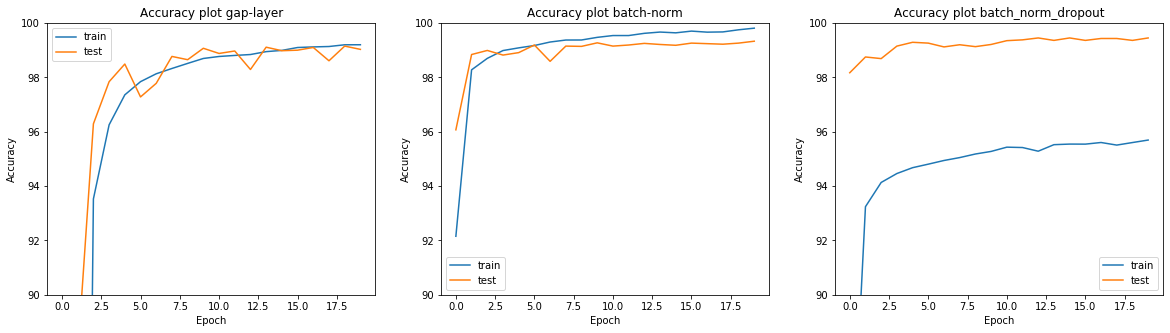

In [63]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))
for idx, experiment in enumerate(experiment_data.keys()):
  axs[idx].plot(summary[experiment]['train']['accuracy'])
  axs[idx].plot(summary[experiment]['test']['accuracy'])
  axs[idx].set_title(f'Accuracy plot {experiment}')
  axs[idx].set_ylabel('Accuracy')
  axs[idx].set_xlabel('Epoch')
  axs[idx].set_ylim([90, 100])
  axs[idx].legend(['train', 'test'], loc='best')
plt.show()

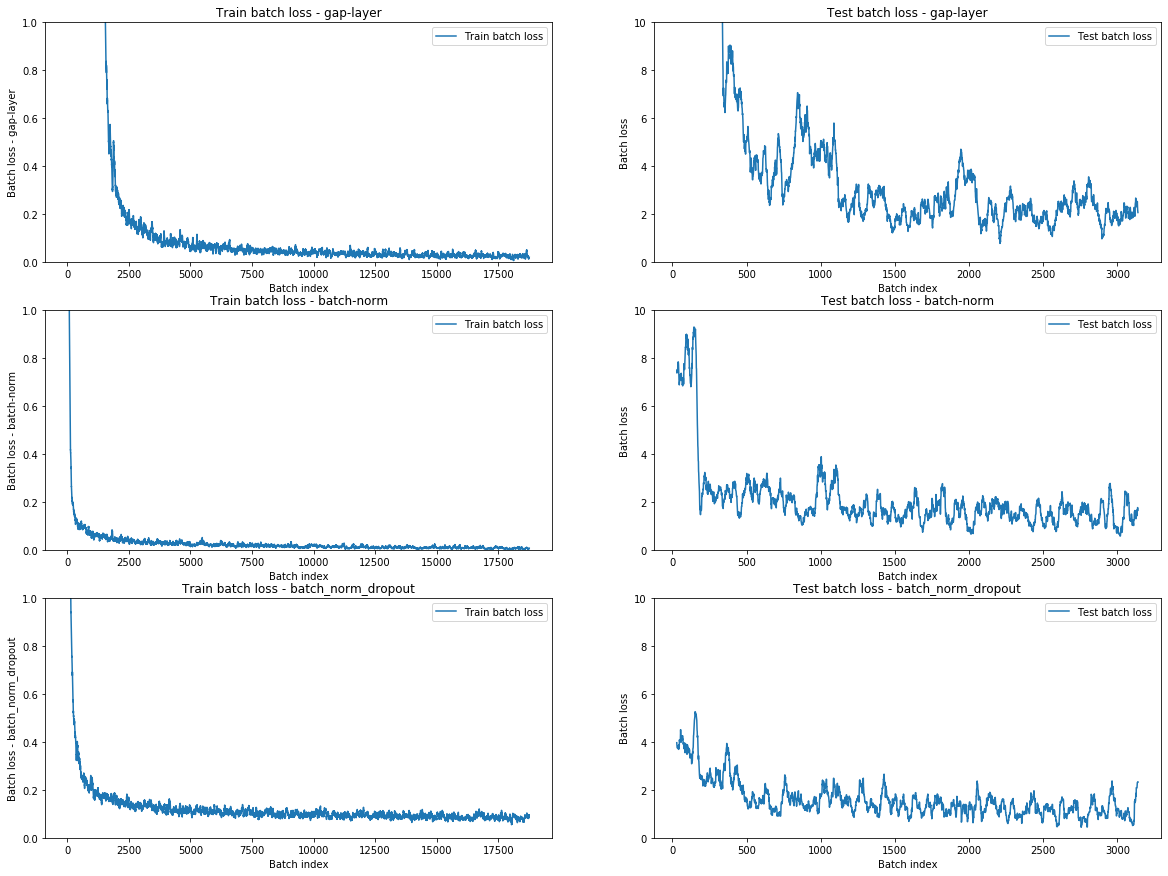

In [64]:
fig, axs = plt.subplots(3, 2, figsize=(20, 15))
window_size = 30
for idx, experiment in enumerate(experiment_data.keys()):
  
  smooth_train_batch_loss = pd.Series(summary[experiment]['train']['train/batch_loss']).rolling(window_size).mean()
  smooth_test_batch_loss = pd.Series(summary[experiment]['test']['test/batch_loss']).rolling(window_size).mean()

  axs[idx][0].plot(smooth_train_batch_loss)
  axs[idx][0].legend([f'Train batch loss'], loc='best')
  axs[idx][0].set_title(f'Train batch loss - {experiment}')
  axs[idx][0].set_ylabel(f'Batch loss - {experiment}')
  axs[idx][0].set_xlabel('Batch index')
  axs[idx][0].set_ylim([0, 1])
  axs[idx][1].plot(smooth_test_batch_loss)
  axs[idx][1].legend([f'Test batch loss'], loc='best')
  axs[idx][1].set_title(f'Test batch loss - {experiment}')
  axs[idx][1].set_ylabel(f'Batch loss')
  axs[idx][1].set_xlabel('Batch index')
  axs[idx][1].set_ylim([0, 10])
plt.show()